# EXAMPLE ON HOW TO GET THE HYBRID BIAS FIELD-LEVEL RESULTS FROM MAP2MAP

Hellooooooo Kate! I hope everything is going wonderful! 

Here I summarise the codes I used to get the field level results with the map2map emulator.

## Some steps prior to computing the fields of the hybrid model

1. First, one needs to have the displacement fields from a Zeldovich simulation and (in case you'd like to compare against a full N-body) from their correspondant N-body simulation, and the linear density field of such simulation (this is for later). Since the map2map emulator was trained on the Quijote simulations, I have prepared one such simulations in the following folder at the atlas cluster (I hope you have access to it, otherwise let me know and I will send you the files):

**N-body displacement: /dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/**

**ZA displacement: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/**

**Linear density: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/den_200.npy**

(Note that /dipc_storage/ is called like that only from our node, atlas-248. From the normal atlas log-in nodes it is just called /dipc/).

2. Once you have the ZA displacement field, you will need to install the map2map emulator from Drew's github repository:

https://github.com/dsjamieson/map2map_emu/

3. To get the emulated displacement field, just run the line (changing the paths to wherever you have the files):

```shell
python m2m.py test --test-in-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --test-tgt-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --in-norms "cosmology.dis" --tgt-norms "cosmology.dis" --crop 128 --crop-step 128 --pad 48 --model d2d.StyledVNet --batches 1 --loader-workers 7 --load-state "map2map/weights/d2d_weights.pt" --callback-at "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/" --test-style-pattern "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/style_fyle.txt"
```
I know this is a very confusing line if it is the first time that you see it. Let me know if you have any trouble. The "style_fyle.txt" is a file that the user has to create containing the Om value of the simulation. Since I used the Quijote fiducial cosmology for this example, it is Om=0.3175. It only contains the number, not the "Om=".
The output of this code will be writen in a file called "._out.npy" so you won't be able to see it with a simple ls!!! Once you run it, just move it with the name you prefer, in our case:
```shell
mv ._out.npy emu_disp.npy
```
Now that we have the emulation and the N-body result, we can compute the fields. 

## Computing the emulated fields 

1. We have to load some modules first and set uo a couple of options for the bacco code

In [1]:
import numpy as np
import bacco
import os
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import deepdish as dd
from pathlib import Path

ngrid = 512 #1024 #512 #256 #128 #256 #1400
nmean=0.01
BoxSize=1000

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}})
bacco.configuration.update({'pknbody' : {'interlacing' : False}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

In [3]:
import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils


2024-07-19 20:12:47.917715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 20:12:48.206149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 20:12:48.207910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 20:12:51.677847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-19 20:12:56.278513: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [4]:
save_plots = True
plot_dir = '../plots/plots_2024-07-23'
Path.mkdir(Path(plot_dir), parents=True, exist_ok=True)
tag_save = '_damp0.75'
#tag_save = '_damp0.1'

2. We create a uniform grid of particles as the Initial Conditions of our emulated simulation

In [5]:
grid = bacco.visualization.uniform_grid(npix=ngrid, L=BoxSize, ndim=3, bounds=False)

3. We read the emulated displacement and move the particles

In [6]:
indicesLH = np.array([10,29,37,40,70,85,127,158,165,184,208,220,240,254,267,274,293,305,336,374,375,388,433,444,
                      464,502,534,542,574,598,605,628,652,663,676,700,702,721,737,762,809,822,825,837,853,864,882,
                      899,901,911,939,948,950,951,964,976,977,1016,1022,1041,1050,1060,1082,1091,1103,1114,1147,
                      1157,1173,1175,1219,1222,1299,1309,1314,1317,1331,1365,1372,1378,1391,1397,1418,1444,1459,
                      1510,1512,1513,1515,1517,1533,1553,1567,1568,1599,1622,1642,1657,1659,1667])
#i = 0
i = list(indicesLH).index(663) #in lbias emu bounds

#pred_disp = np.load('/dipc_storage/mpelle/Yin_data/Quijote/LH%04d/pred_pos_%04d.npy'%(indicesLH[i], indicesLH[i]))
pred_disp = np.load('/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/pred_pos_%04d.npy'%(indicesLH[i], indicesLH[i]))

pred_pos = bacco.scaler.add_displacement(None,
                             pred_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2024-07-19 20:13:03,740 bacco.scaler : Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [7]:
'/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/pred_pos_%04d.npy'%(indicesLH[i], indicesLH[i])

'/cosmos_storage/home/mpelle/Yin_data/Quijote/LH0663/pred_pos_0663.npy'

Now we have the emulated positions coming from map2map :)

4. We take this emulated simulation and compute the fields that will be used for the hybrid model. To do this we also need the linear density field of the Quijote simulation.

We read the linear density field of the Quijote simulation:

In [8]:
#dens_yin = np.load('/dipc_storage/mpelle/Yin_data/Quijote/LH%04d/lin_den_%04d.npy'%(indicesLH[i], indicesLH[i]))
dens_yin = np.load('/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/lin_den_%04d.npy'%(indicesLH[i], indicesLH[i]))

Then initialise the hybrid bias class:

In [9]:
k_nyq = np.pi * ngrid / BoxSize

#damping_scale = k_nyq
# try matching damping scale to emu
damping_scale = 0.75
#damping_scale = 0.1

bmodel = bacco.BiasModel(sim=None, linear_delta=dens_yin[0], 
                         ngrid=ngrid, ngrid1=ngrid,
                         sdm=True, mode="dm", BoxSize=BoxSize,
                         npart_for_fake_sim=ngrid, damping_scale=damping_scale,
                         bias_model='expansion', deposit_method="cic",
                         use_displacement_of_nn=False, interlacing=False,
                         )

2024-07-19 20:13:05,550 bacco.BiasModel : Initialising Bias Model class ...


Ask the bias class to compute the bias fields in Lagrangian coordinates:

In [10]:
bias_fields = bmodel.bias_terms_lag()

2024-07-19 20:13:07,595 bacco.BiasModel : Computing delta_to_tidal_field with 12 threads...
2024-07-19 20:13:07,596 bacco.BiasModel : fttw plan
2024-07-19 20:13:07,597 bacco.BiasModel : Computing linear field ...
2024-07-19 20:13:07,598 bacco.BiasModel : Memory used: 6.947815424 Gigabytes
2024-07-19 20:13:07,604 bacco.BiasModel : fttw freqs
2024-07-19 20:13:07,604 bacco.BiasModel : tidk freqs
2024-07-19 20:13:13,432 bacco.BiasModel : ifft
2024-07-19 20:13:42,271 bacco.BiasModel : Computing laplacian ...
2024-07-19 20:13:42,273 bacco.BiasModel : Memory used: 11.785142272 Gigabytes
2024-07-19 20:13:43,490 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-19 20:13:43,492 bacco.BiasModel : Memory used: 12.3210752 Gigabytes
2024-07-19 20:13:43,738 bacco.BiasModel : Computing delta squared ...
2024-07-19 20:13:43,739 bacco.BiasModel : Memory used: 12.857942016 Gigabytes
2024-07-19 20:13:44,814 bacco.BiasModel : Computing tidal component G2 with the given tidal field
202

Weight the emulated positions by the lagrangian fields: 

In [11]:
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=pred_pos,
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                              interlacing=False)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

2024-07-19 20:13:57,179 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:13:57,181 bacco.statistics : starting deposit 1
2024-07-19 20:13:59,271 bacco.statistics :  mesh done in 2.09 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:00,053 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:00,054 bacco.statistics : starting deposit 1
2024-07-19 20:14:01,702 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:02,305 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:02,306 bacco.statistics : starting deposit 1
2024-07-19 20:14:03,973 bacco.statistics :  mesh done in 1.67 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:04,823 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:04,824 bacco.statistics : starting deposit 1
2024-07-19 20:14:06,705 bacco.statistics :  mesh done in 1.88 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:07,310 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:07,311 bacco.statistics : starting deposit 1
2024-07-19 20:14:09,010 bacco.statistics :  mesh done in 1.7 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


5. We repeat the same procedure but with the Quijote displacements to get the N-body results:

In [12]:
# seems like this was wrong, should go to the same index as above
sim_disp = np.load('/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/dis_%04d.npy'%(indicesLH[i], indicesLH[i]))
#sim_disp = np.load('/dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/dis_200.npy')
#sim_disp = np.load('/cosmos_storage/home/mpelle/Yin_data/Fiducial/Quijote/200/dis_200.npy')

sim_pos = bacco.scaler.add_displacement(None,
                             sim_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2024-07-19 20:14:13,374 bacco.scaler : Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [13]:
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=sim_pos,
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                              interlacing=False)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

2024-07-19 20:14:15,790 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:15,791 bacco.statistics : starting deposit 1
2024-07-19 20:14:17,443 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:18,064 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:18,065 bacco.statistics : starting deposit 1
2024-07-19 20:14:19,724 bacco.statistics :  mesh done in 1.66 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:20,326 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:20,327 bacco.statistics : starting deposit 1
2024-07-19 20:14:21,993 bacco.statistics :  mesh done in 1.67 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:22,610 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:22,611 bacco.statistics : starting deposit 1
2024-07-19 20:14:24,265 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 20:14:24,872 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 20:14:24,873 bacco.statistics : starting deposit 1
2024-07-19 20:14:26,523 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


Let's plot a couple of them to check that everything went as expected:

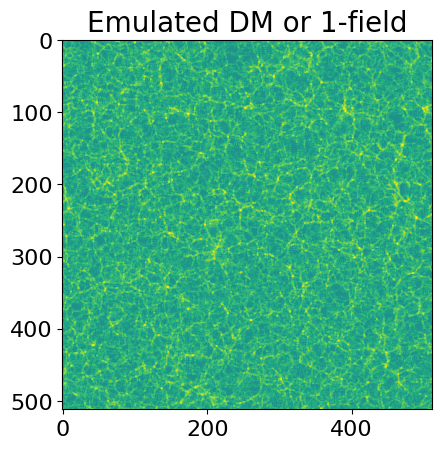

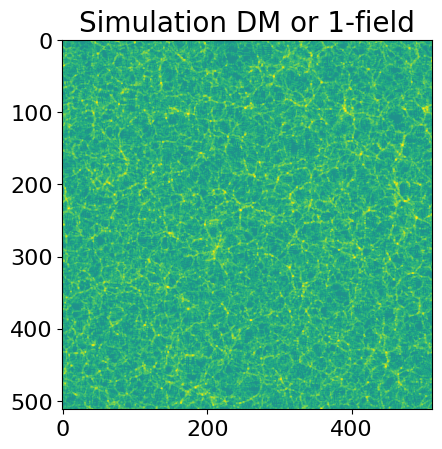

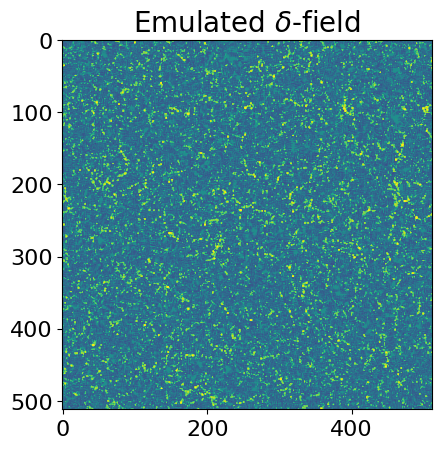

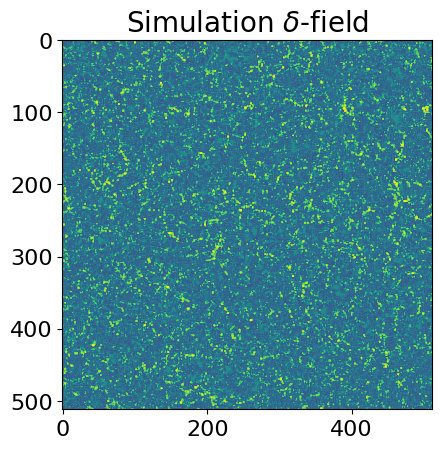

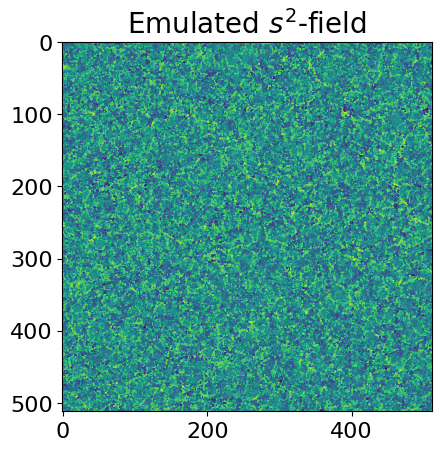

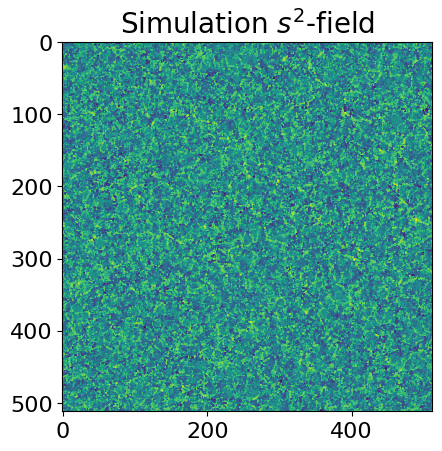

In [14]:
# Set normalisation
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.imshow(bias_terms_eul_pred[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated DM or 1-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation DM or 1-field', size=20)
plt.show()

#Plot delta-term
plt.imshow(bias_terms_eul_pred[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $\delta$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $\delta$-field', size=20)
plt.show()

#Plot tidal-term
plt.imshow(bias_terms_eul_pred[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $s^2$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $s^2$-field', size=20)
plt.show()

#### Everything looks good so far! I am as surprised as you are :)

## Computing the emulated spectra

Let's see what the results are from a more quantitative point of view. Let's compute their power spectra and compare N-body versus emulated results.

1. We need to define the arguments for the power spectrum computation within bacco (but you can use any power spectrum calculator of course).

In [15]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
# Ob = 0.049
# Om = 0.3175
# hubble = 0.6711
# ns = 0.9624
# sigma8 = 0.834
# we should be reading in from the idx
fn_cosmo_params = '/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/param_%04d.txt'%(indicesLH[i], indicesLH[i])
Om, Ob, hubble, ns, sigma8 = np.loadtxt(fn_cosmo_params)

cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob,
        hubble=hubble,
        ns=ns,
        sigma8=sigma8,
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
print(cosmopars)

cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-07-19 20:14:30,989 bacco.cosmo :    initialization took 0.000 secs


{'omega_cdm': 0.27604999999999996, 'omega_baryon': 0.04625, 'hubble': 0.7015, 'ns': 0.9607, 'sigma8': 0.8311, 'tau': 0.0561, 'A_s': None, 'neutrino_mass': 0.0, 'w0': -1, 'wa': 0, 'tag': 'cosmo_BOSS'}


In [16]:

##################

# These are the important arguments of the P(k)
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':False,
                  'kmin':0.01,
                  'kmax':1.0,
                  'nbins':50,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'compute_power2d':False}


#This is what I was talking about some corrections one can make to the P(k) computation
#Not very important though, ask Raul if you want to know more
lt_k = np.logspace(np.log10(np.pi / BoxSize), np.log10(2 * np.pi / BoxSize * ngrid), num=90)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_Quijote, expfactor=cosmo_Quijote.expfactor, wavemode=lt_k)

#Normalise the grid before P(k) computation
#one can normalise later too, I chose to do it here
norm=ngrid**3.
bias_terms_eul_norm_pred = bias_terms_eul_pred/norm


2024-07-19 20:14:31,539 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.275 secs
2024-07-19 20:14:31,541 bacco.cosmo :    created Pk(z=0) tab from k 0.0007014999999999996 to 100000.0 h/Mpc


## Load and setup emu

2. And compute the power spectrum of the 15 auto and cross terms

In [17]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_pred.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(ii, prod[ii])
    power_term_pred = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_pred[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_pred[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_pred.append(power_term_pred)


2024-07-19 20:14:35,791 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-07-19 20:14:35,795 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs


0 [0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.390120 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.351220 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000259 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:38,956 bacco.statistics :  ...done in 3.17 s
2024-07-19 20:14:38,957 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


1 [0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.08802e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.357605 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.362579 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000297 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:42,362 bacco.statistics :  ...done in 3.4 s
2024-07-19 20:14:42,363 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


2 [0 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.40599e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.365120 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.349220 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000241 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:45,651 bacco.statistics :  ...done in 3.29 s
2024-07-19 20:14:45,652 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


3 [0 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.368779 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.379178 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000231 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:48,938 bacco.statistics :  ...done in 3.29 s
2024-07-19 20:14:48,941 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


4 [0 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.378055 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.358690 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000222 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:52,198 bacco.statistics :  ...done in 3.26 s
2024-07-19 20:14:52,200 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


5 [1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) -1.08802e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.382788 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.358624 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000375 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:55,539 bacco.statistics :  ...done in 3.34 s
2024-07-19 20:14:55,540 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


6 [1 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) 5.40599e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.390352 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.359162 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000284 secs
bacco.power : Deallocating arrays


2024-07-19 20:14:58,829 bacco.statistics :  ...done in 3.29 s
2024-07-19 20:14:58,830 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


7 [1 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.364246 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.361325 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000236 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:01,960 bacco.statistics :  ...done in 3.13 s
2024-07-19 20:15:01,961 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


8 [1 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.367567 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.362766 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000979 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:05,105 bacco.statistics :  ...done in 3.14 s
2024-07-19 20:15:05,106 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


9 [2 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40599e-06 (grid1) 5.40599e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.366810 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.367105 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000293 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:08,243 bacco.statistics :  ...done in 3.14 s
2024-07-19 20:15:08,245 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


10 [2 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40599e-06 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.365623 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.366234 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000291 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:11,458 bacco.statistics :  ...done in 3.21 s
2024-07-19 20:15:11,460 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


11 [2 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40599e-06 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.372035 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.364893 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000264 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:14,866 bacco.statistics :  ...done in 3.41 s
2024-07-19 20:15:14,867 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


12 [3 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97825e-06 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.396699 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.426268 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000690 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:18,286 bacco.statistics :  ...done in 3.42 s
2024-07-19 20:15:18,293 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


13 [3 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97825e-06 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.395564 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.375853 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000238 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:21,648 bacco.statistics :  ...done in 3.35 s
2024-07-19 20:15:21,649 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


14 [4 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -7.88716e-13 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.408753 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.405340 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000240 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:24,933 bacco.statistics :  ...done in 3.28 s


3. We repeat the same for the Quijote N-body results

In [18]:
#Normalise the grid before P(k) computation
norm=ngrid**3.
bias_terms_eul_norm_sim = bias_terms_eul_sim/norm

#Compute the P(k) of the 15 terms
power_all_terms_sim = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(ii, prod[ii])
    power_term_sim = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_sim[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_sim[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_sim.append(power_term_sim)


2024-07-19 20:15:27,173 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


0 [0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.376273 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.358078 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000289 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:30,314 bacco.statistics :  ...done in 3.14 s
2024-07-19 20:15:30,315 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


1 [0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.15649e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.357638 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.361074 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000364 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:33,704 bacco.statistics :  ...done in 3.39 s
2024-07-19 20:15:33,705 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


2 [0 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.4054e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.361762 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.350492 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000445 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:36,940 bacco.statistics :  ...done in 3.23 s
2024-07-19 20:15:36,941 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


3 [0 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.402640 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.361073 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000288 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:40,260 bacco.statistics :  ...done in 3.32 s
2024-07-19 20:15:40,261 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


4 [0 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.343555 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.362840 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000495 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:43,532 bacco.statistics :  ...done in 3.27 s
2024-07-19 20:15:43,533 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


5 [1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) -1.15649e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.345752 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.345921 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000383 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:46,640 bacco.statistics :  ...done in 3.11 s
2024-07-19 20:15:46,641 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


6 [1 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) 5.4054e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.357933 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.367378 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000495 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:49,776 bacco.statistics :  ...done in 3.14 s
2024-07-19 20:15:49,778 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


7 [1 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.346337 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.355487 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000292 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:53,044 bacco.statistics :  ...done in 3.27 s
2024-07-19 20:15:53,046 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


8 [1 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.352875 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.359379 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000382 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:56,346 bacco.statistics :  ...done in 3.3 s
2024-07-19 20:15:56,347 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


9 [2 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.4054e-06 (grid1) 5.4054e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.381039 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.365825 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000976 secs
bacco.power : Deallocating arrays


2024-07-19 20:15:59,658 bacco.statistics :  ...done in 3.31 s
2024-07-19 20:15:59,659 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


10 [2 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.4054e-06 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.340782 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.368306 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000501 secs
bacco.power : Deallocating arrays


2024-07-19 20:16:03,136 bacco.statistics :  ...done in 3.48 s
2024-07-19 20:16:03,138 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


11 [2 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.4054e-06 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.348405 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.353181 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000231 secs
bacco.power : Deallocating arrays


2024-07-19 20:16:06,400 bacco.statistics :  ...done in 3.26 s
2024-07-19 20:16:06,401 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


12 [3 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97814e-06 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.350381 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.400600 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000232 secs
bacco.power : Deallocating arrays


2024-07-19 20:16:09,594 bacco.statistics :  ...done in 3.19 s
2024-07-19 20:16:09,595 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


13 [3 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97814e-06 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.354935 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.380569 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000293 secs
bacco.power : Deallocating arrays


2024-07-19 20:16:12,990 bacco.statistics :  ...done in 3.4 s
2024-07-19 20:16:12,992 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


14 [4 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.09598e-12 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.390093 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.354628 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000362 secs
bacco.power : Deallocating arrays


2024-07-19 20:16:16,172 bacco.statistics :  ...done in 3.18 s


3.5 Load emu 

In [19]:
cosmo_params_emu_quijote = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_Quijote)

In [20]:
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
kk = power_all_terms_pred[ii]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]
_, pnn_emu = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote)

4. And we plot them to see how accurate the map2map emulator is in the 2-point statistics:

In [22]:
labels_pnn = ['$1 1$',
 '$1 \\delta$',
 '$1 \\delta^2$',
 '$1 s^2$',
 '$ 1 \\nabla^2\\delta$',
 '$\\delta \\delta$',
 '$\\delta \\delta^2$',
 '$\\delta s^2$',
 '$\\delta \\nabla^2\\delta$',
 '$\\delta^2 \\delta^2$',
 '$\\delta^2 s^2$',
 '$\\delta^2 \\nabla^2\\delta$',
 '$s^2 s^2$',
 '$s^2 \\nabla^2\\delta$',
 '$\\nabla^2\\delta \\nabla^2\\delta$']

/tmp/ipykernel_320158/1849174803.py:20: RuntimeWarning: invalid value encountered in divide
  ax_err[contf].semilogx(kk, (pk_pred-pk_sim)/pk_sim,
/tmp/ipykernel_320158/1849174803.py:22: RuntimeWarning: divide by zero encountered in divide
  ax_err[contf].semilogx(kk_emu, (pnn_emu[ii]-pk_sim[i_k_emu])/pk_sim[i_k_emu],


18
Saving ../plots/plots_2024-07-17/quijote_LH663_pnn_damp0.1.png


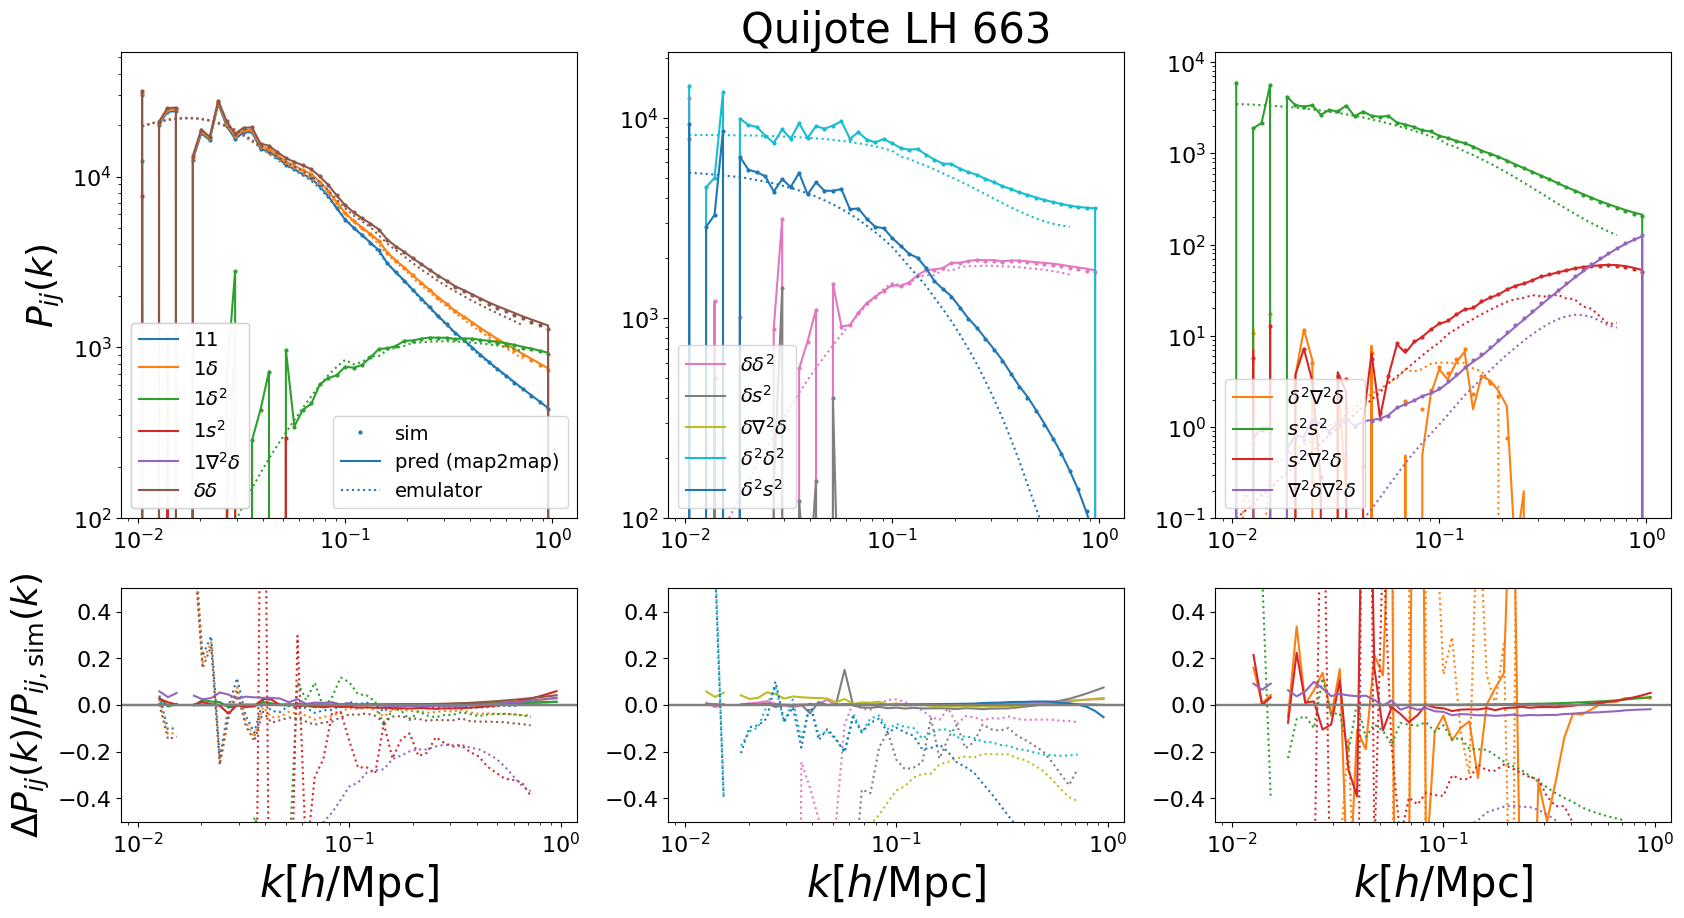

In [23]:
fig, axarr = plt.subplots(2, 3, figsize=(20,10), height_ratios=[2,1])
ax, ax_err = axarr

contf=0
for ii in range(len(power_all_terms_sim)):
    #mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    # pk_sim = power_all_terms_sim[ii]['pk'][mask]
    # pk_pred = power_all_terms_pred[ii]['pk'][mask]
    
    pk_sim = power_all_terms_sim[ii]['pk']
    pk_pred = power_all_terms_pred[ii]['pk']

    ax[contf].loglog(kk, pk_sim,
                       'o', markersize=2, color='C'+str(ii))
    ax[contf].loglog(kk, pk_pred,
                       color='C'+str(ii), label=labels_pnn[ii])
    ax[contf].loglog(kk_emu, pnn_emu[ii], ls=':', color='C'+str(ii), 
                     )
    
    ax_err[contf].semilogx(kk, (pk_pred-pk_sim)/pk_sim,
                           color='C'+str(ii))
    ax_err[contf].semilogx(kk_emu, (pnn_emu[ii]-pk_sim[i_k_emu])/pk_sim[i_k_emu], 
                         ls=':', color='C'+str(ii),)
    
    ax[contf].legend(loc='lower left', frameon=True, fancybox=True, fontsize=14)
    
    ax_err[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    ax_err[contf].axhline(0, ls='-', color='grey')
    ax_err[contf].set_ylim(-0.5, 0.5)
    
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$P_{ij}(k)$', size=26)
ax_err[0].set_ylabel(r'$\Delta P_{ij}(k) / P_{ij,\text{sim}}(k)$', size=26)
ax[0].set_ylim(1e2)
ax[1].set_ylim(1e2)
ax[2].set_ylim(1e-1)

# where some data has already been plotted to ax
handles, labels = ax[0].get_legend_handles_labels()
lines = ax[0].get_lines()
print(len(lines))
legend = ax[0].legend([lines[i] for i in [0,1,2]], ["sim", "pred (map2map)", "emulator"], loc='lower right',
                      frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend)

legend_orig = ax[0].legend(handles, labels, loc='lower left',
                           frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend_orig)
# from matplotlib.lines import Line2D
# handles, labels = ax[0].get_legend_handles_labels()
# line_emu = Line2D([0], [0], ls=':', color='C'+str(0), label='emulator')
# line_pred = Line2D([0], [0], ls='-', color='C'+str(0), label='pred (map2map)')
# line_sim = Line2D([0], [0], marker='o', color='C'+str(0), label='sim')
# handles.extend([line_emu, line_pred, line_sim]) 
# ax[0].legend(handles=handles, loc='lower left', frameon=True, fancybox=True, fontsize=14)


# ax[1].set_title(r'Fiducial: $z=0$, $\Omega_{\rm m}=0.3175$, $\Omega_{\rm b}=0.049$, $\sigma_8=0.834$, $H_0=67.11$, $n_s=0.96$',
#                  fontsize=30)
ax[1].set_title(f'Quijote LH {indicesLH[i]}',
                 fontsize=30)
#plt.show()

if save_plots:
    print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnn{tag_save}.png')
    plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnn{tag_save}.png', bbox_inches='tight')

focus on p11 and pdd

/tmp/ipykernel_320158/2823780974.py:22: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls=':', alpha=alpha, color=color, lw=lw)


Saving ../plots/plots_2024-07-17/quijote_LH663_pnnzooom_damp0.1.png


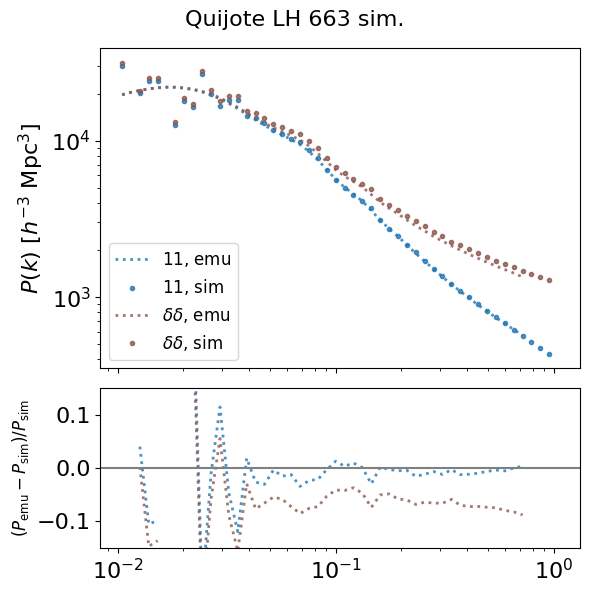

In [24]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

plt.suptitle(f'Quijote LH {indicesLH[i]} sim.', fontsize=16)


color_pdd = 'C'+str(5)

k = kk
lw = 2


is_pnn = [0,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms_sim[i_pnn]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], ls=':', alpha=alpha, label=f'{labels_pnn[i_pnn]}, emu', color=color, lw=lw)
    axarr[0].plot(kk, pk_obj['pk'], ls='None', marker='o', markersize=3, alpha=alpha, label=f'{labels_pnn[i_pnn]}, sim', color=color)
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls=':', alpha=alpha, color=color, lw=lw)

ax1.axhline(0.0, color='grey')

ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

if save_plots:
    print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
    plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

### And that's it. Thanks for reading until here!

### Marcos :)

# Actually no! Now we combine with a given set of bias parameters :)

In [25]:
biases = [1, 0, 0, 0] # b1, b2, bs2, blap

bias_extended = np.concatenate([[1], biases])

prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))

sum_terms_power = 0
for ii in range(0,15):
    fac = 2 if prod[ii,0]!=prod[ii,1] else 1
    sum_terms_power += bias_extended[prod[ii,0]] * bias_extended[prod[ii,1]] * power_all_terms_pred[ii]['pk'] * fac

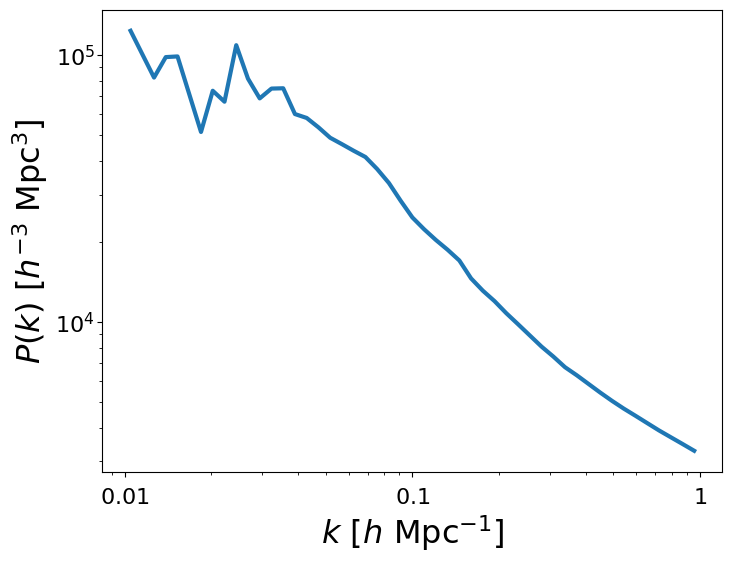

In [26]:
kk = power_all_terms_pred[0]['k']
sum_terms_power
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

mask = sum_terms_power > 0
ax.loglog(kk[mask], sum_terms_power[mask], lw=3)

ax.set_xlabel(r'$k \,\, [h \,\, \mathrm{Mpc}^{-1}]$', size=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, \mathrm{Mpc}^{3}]$', size=23)
bacco.set_logticks(ax)

plt.show()